In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [14]:
theano.config.floatX ='float32'

class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
#         self.initialize_gradients()
    
    def initialize_gradients(self):
        grads = T.grad(self._expr, self._extra_vars)
        self.integrators  = [Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars) for grad in grads]

    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        dargs = [out * integrate(*inputs) for integrate in self.integrators]
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [15]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

In [16]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)

    
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
    lower =  e_true_bins.lo.to_value(u.TeV)
    upper = e_true_bins.hi.to_value(u.TeV)

    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(lower, upper):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
    aeff = T.constant(aeff)
    

    counts *= aeff
    counts *= theano.shared(observation.livetime.to_value(u.s))
    edisp = observation.edisp.pdf_matrix
    edisp = T.constant(edisp)
    
    if fit_range:
        idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))
        return T.dot(counts, edisp)[idx[0]:idx[1]]

    return T.dot(counts, edisp)

In [17]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]
energy_bins = observation.on_vector.energy.bins

In [18]:
def wstat_model_symbolic(mu_sig, observation, fit_range):
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

625it [00:15, 41.31it/s]


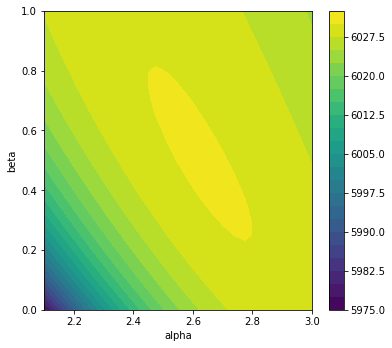

In [19]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)



amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)

zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
    mu_sig = cf.eval({amplitude: 4.0, alpha: al, beta: be})
    
    p, _ = wstat_model_symbolic(mu_sig, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [26]:
on_data = observation.on_vector.data.data.value
off_data = observation.off_vector.data.data.value
    
on_data, off_data, obs_alpha = apply_range(on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observation.alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
#     BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
#     amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=2, lower=0, testval=4)
#     alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=1, lower=0, testval=2.5)
#     beta = pm.TruncatedNormal('beta', mu=0.5, sd=1, lower=0, testval=0.5)
    
    amplitude = pm.HalfFlat('amplitude',testval=4)
    alpha = pm.HalfFlat('alpha', testval=2.5)
    beta = pm.HalfFlat('beta', testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range,)

#     mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     b = pm.Poisson('background', mu=mu_b, observed=off_data)    
#     s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * off_data, observed=on_data)

In [27]:
model.test_point

{'amplitude_log__': array(1.3862944, dtype=float32),
 'alpha_log__': array(0.91629076, dtype=float32),
 'beta_log__': array(-0.6931472, dtype=float32),
 'mu_b_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [28]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = nan: 100%|██████████| 933/933 [00:31<00:00, 29.44it/s]    


{'amplitude_log__': array(30.591864, dtype=float32),
 'alpha_log__': array(30.121859, dtype=float32),
 'beta_log__': array(28.51242, dtype=float32),
 'mu_b_log__': array([-447.8497  , -447.8497  , -447.8497  ,   46.244965, 2470.9119  ,
          29.205568,   29.205568,   29.205568,   29.205568,   29.205568,
          29.205568,   29.205568,   29.205568,   29.205568,   29.205568,
          29.205568,   29.205568,   29.205568,   29.205568,   29.205568,
          29.205568,   29.205568,   29.205568,   29.205568,   29.205568,
          29.205568,   29.205568,   29.205568,   29.205568,   29.205568,
          29.205568,   29.205568,   29.205568,   29.205568], dtype=float32),
 'amplitude': array(1.9314237e+13, dtype=float32),
 'alpha': array(1.2071381e+13, dtype=float32),
 'beta': array(2.4142762e+12, dtype=float32),
 'mu_b': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2132015e+20,
                  inf, 4.8285546e+12, 4.8285546e+12, 4.8285546e+12,
        4.8285546e+12, 4.8285546e+

In [ ]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(1000, chains=5, cores=5, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 7,377.7:   1%|          | 2113/200000 [05:09<7:26:17,  7.39it/s]    

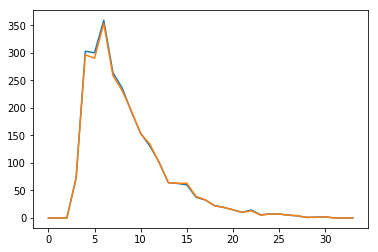

In [33]:
plt.plot(map_estimate['mu_b'])
plt.plot(off_data)

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e5a974908>,
      dtype=object)

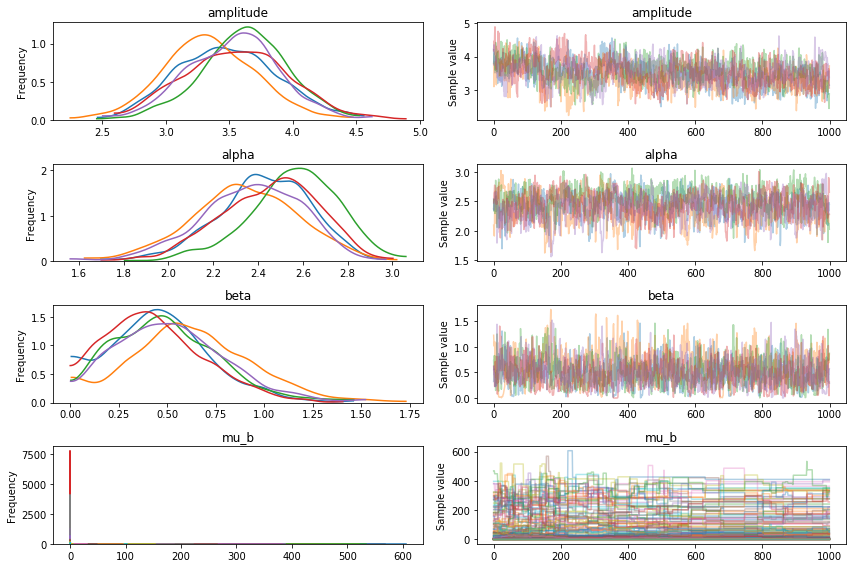

In [39]:
pm.traceplot(trace)

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8ef769a58>,
      dtype=object)

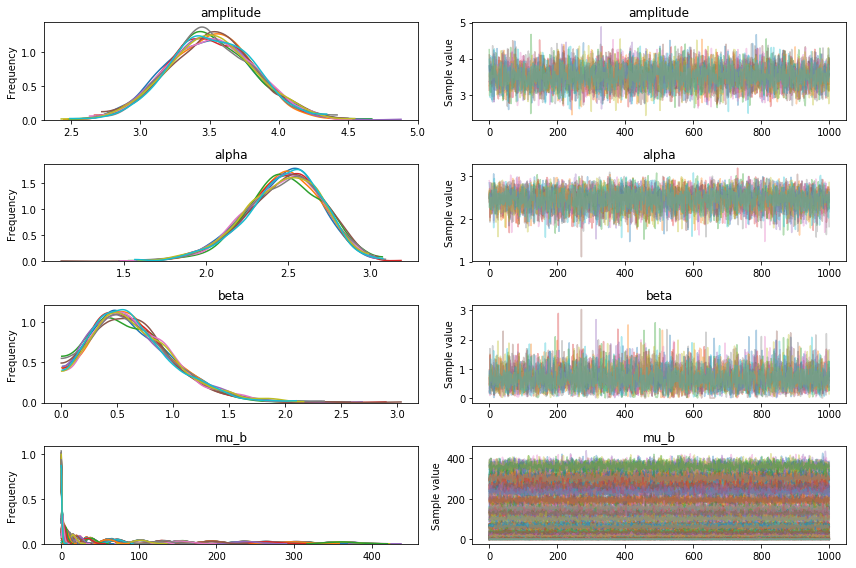

In [139]:
pm.traceplot(trace)

In [161]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = pm.Normal('mu', mu=10, sd=5)
    obs = pm.Normal('obs', mu=mu, sd=sigma, observed=np.random.randn(100) + 10)

    trace = pm.sample(1000, tune=1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3270.74draws/s]


In [162]:
model.test_point

{'sigma_log__': array(-0.22579135), 'mu': array(10.)}

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8a657b6a0>,
      dtype=object)

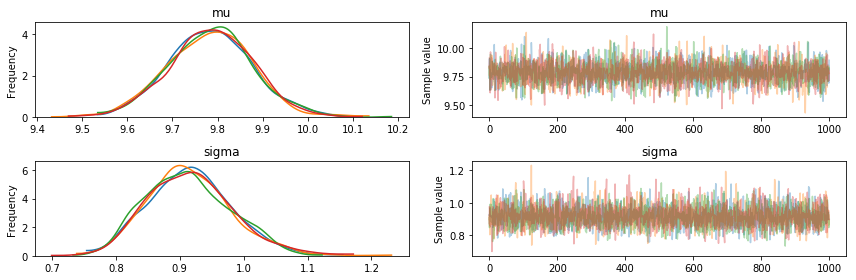

In [163]:
pm.traceplot(trace)